In [10]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy import stats
from nitime.algorithms import multi_taper_psd
from nitime.utils import dpss_windows
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlim, ylim, show, imshow, xlabel, ylabel, bar, figure, title
from matplotlib import rcParams
from numpy import hanning, where, histogram, arange
rcParams['figure.figsize'] = (12,5)


Spikes de neurônio do hipocampo
100 trials de 1s após uma decisão do rato
Objetivo: determinar como o LFP impacta na taxa de disparos do neurônio 


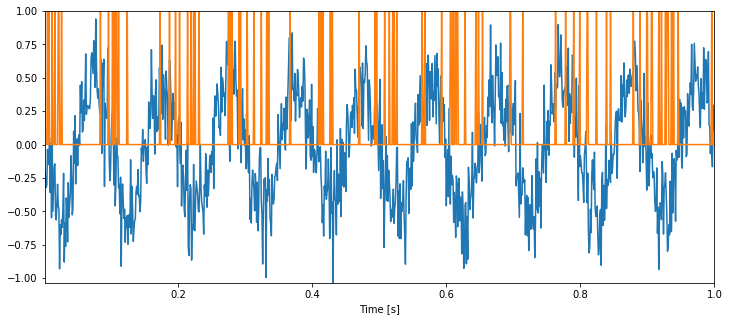

In [45]:
#Análise visual

data = sio.loadmat('Aula15-spikes-LFP-1.mat')  
y = data['y']                               
n = data['n']                                
t = data['t'].reshape(-1)                    
plot(t,y[1,:])                               

plot(t,n[1,:])
xlabel('Time [s]')
plt.autoscale(tight=True)

#O que é possível observar?
#Uma senoide bem clara com frequência de 10 Hz, tempo padrão


Text(0, 0.5, 'Voltage [mV]')

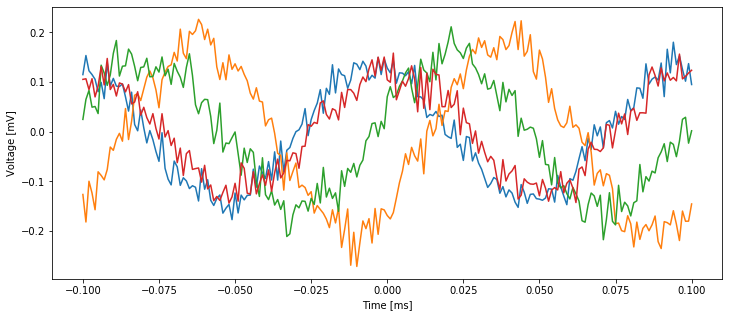

In [17]:
#STA - Algoritmo bem simples para plotar spikes através do lfp

win = 100                                     
K = np.shape(n)[0]                             
N = np.shape(n)[1]                             
STA = np.zeros([K,2*win+1])                    
for k in np.arange(K):                         
    spike_times = np.where(n[k,:]==1)[0]       
    counter=0
    for spike_t in spike_times:                
        if win < spike_t < N-win-1:            
            STA[k,:] = STA[k,:] + y[k,spike_t-win:spike_t+win+1]
            counter += 1
    STA[k,:] = STA[k,:]/counter

dt = t[1]-t[0]                    
lags = np.arange(-win,win+1)*dt   
plot(lags, STA[0,:])              
plot(lags, STA[5,:])
plot(lags, STA[9,:])
plot(lags, STA[15,:])
xlabel('Time [ms]')               
ylabel('Voltage [mV]')



Text(0, 0.5, 'Voltage [mV]')

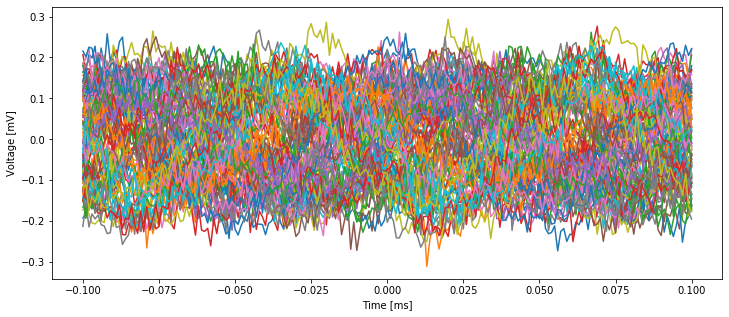

In [18]:
plot(lags,np.transpose(STA))        
xlabel('Time [ms]')
ylabel('Voltage [mV]')


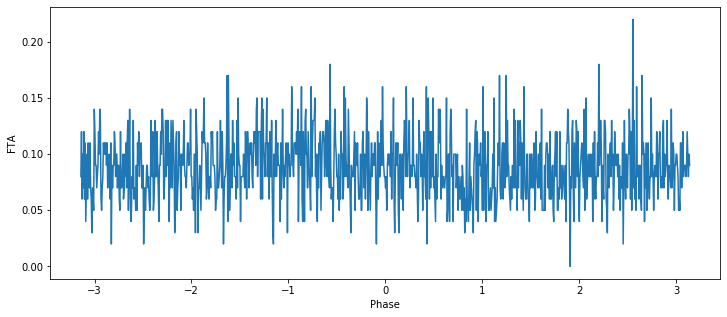

In [19]:
#FTA

def FTA_function(y,n,t,Wn):                  
    dt = t[1]-t[0]                           
    fNQ = 1/dt/2                             
    ord  = 100                               
    b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming'); 
    FTA=np.zeros([K,N])                      
    for k in np.arange(K):                  
        Vlo = signal.filtfilt(b, 1, y[k,:])  
        phi = np.angle(signal.hilbert(Vlo))  
        indices = np.argsort(phi)            
        FTA[k,:] = n[k,indices]              
    phi_axis = np.linspace(-np.pi,np.pi,N)   
    return np.mean(FTA,0), phi_axis

Wn = [9,11]                                  
FTA, phi_axis = FTA_function(y,n,t,Wn)       

plot(phi_axis, FTA)
xlabel('Phase')
ylabel('FTA');
Calcule o STA e  FTA. Existe alguma associação entre os spikes e o LFP?


In [20]:
SYY = np.zeros(int(N/2+1))                                       
SNN = np.zeros(int(N/2+1))                                       
SYN = np.zeros(int(N/2+1), dtype=complex)                        

for k in np.arange(K):                                           
    yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    
    nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   
    SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  
    SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  
    SYN = SYN + (          yf*np.conj(nf)   )/K                  

cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     
f = np.fft.rfftfreq(N, dt)


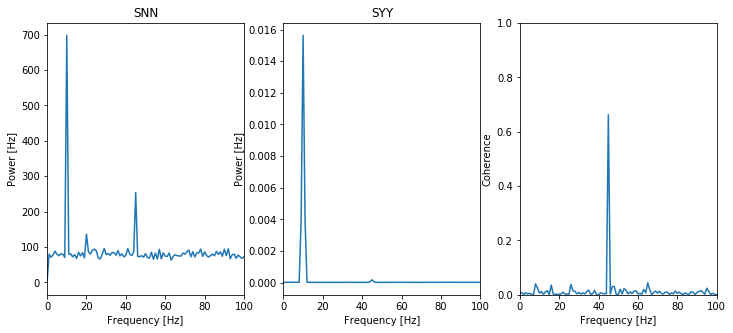

In [21]:
#Coerência Campo Spike

plt.subplot(1,3,1)         
plot(f,SNN)
plt.xlim([0, 100])
xlabel('Frequency [Hz]')
ylabel('Power [Hz]')
title('SNN')

plt.subplot(1,3,2)        
T = t[-1]
plot(f,dt**2/T*SYY)        
plt.xlim([0, 100])
xlabel('Frequency [Hz]')
ylabel('Power [Hz]')
title('SYY')

plt.subplot(1,3,3)       
plot(f,cohr)
plt.xlim([0, 100])
plt.ylim([0, 1])
xlabel('Frequency [Hz]')
ylabel('Coherence');


Text(0.5, 1.0, 'SYY')

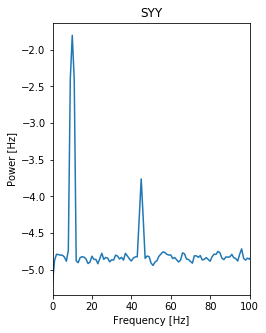

In [27]:
#Colocar na escala decibel para enxergar o pico que aparece no 45

plt.subplot(1,3,2)        
T = t[-1]
y_scaled = 0.1*y
plot(f,np.log10(dt**2/T*SYY))        
plt.xlim([0, 100])
xlabel('Frequency [Hz]')
ylabel('Power [Hz]')
title('SYY')

#Quando tem ou não coerência? Quando existe uma relação de FASE - sinais na mesma direção

Impacto da taxa de disparos na Coerência Campo-Spike

- Se a coerência entre o sinal de EEG das regiões A e B é maior que entre as regiões A e C, podemos concluir que existe uma coordenação mais forte entre A e B.

Como medir? Multiplicando por 0.1



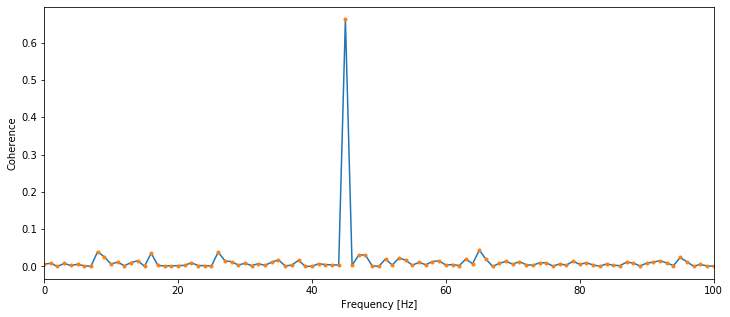

In [37]:
#Impacto da taxa de disparos na Coerência Campo-Spike
def coherence(n,y,t):                           
    K = np.shape(n)[0]                          
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N/2+1))
    SNN = np.zeros(int(N/2+1))
    SYN = np.zeros(int(N/2+1), dtype=complex)
    for k in np.arange(K):
        yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    
        nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   
        SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                 
        SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K              
        SYN = SYN + (          yf*np.conj(nf)   )/K                  
    cohr = np.real(SYN*np.conj(SYN)) / SYY / SNN                     
    f = np.fft.rfftfreq(N, dt)                                       
    return (cohr, f, SYY, SNN, SYN)

[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)           
plot(f,cohr)
plt.xlim([0, 100])
[cohr, f, SYY, SNN, SYN] = coherence(n,y_scaled,t)    
plot(f,cohr,'.');
xlabel('Frequency [Hz]')
ylabel('Coherence');


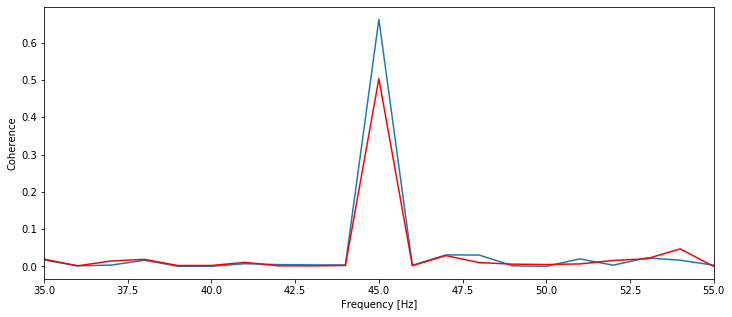

In [39]:
def thinned_spike_train(n, thinning_factor):              
    n_thinned = np.copy(n)                                
    for k in np.arange(K):                                
        spike_times = np.where(n[k,:]==1)                
        n_spikes = np.size(spike_times)                   
        spike_times_random = spike_times[0][np.random.permutation(n_spikes)]    
        n_remove=int(np.floor(thinning_factor*n_spikes))  
        n_thinned[k,spike_times_random[0:n_remove-1]]=0  
    return n_thinned

[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)                          
plot(f,cohr)
[cohr, f, SYY, SNN, SYN] = coherence(thinned_spike_train(n,0.5),y,t) 
plot(f,cohr, 'r')
plt.xlim([35, 55])
xlabel('Frequency [Hz]')
ylabel('Coherence');


#Se tiver coerência com o LFP, vai ter uma coerência maior


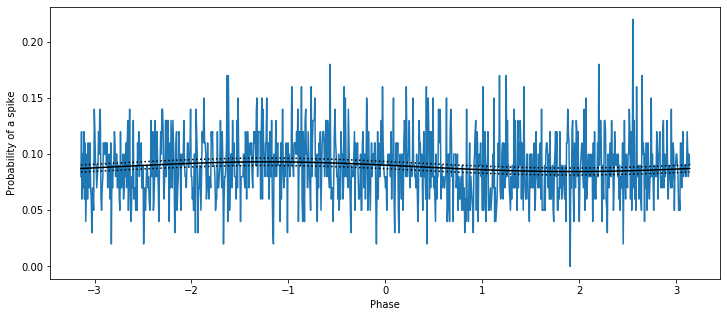

In [41]:
#Processos Pontuais da Coerência Campo-Spike

dt = t[1]-t[0]                     
fNQ = 1/dt/2                      
Wn = [9,11]                        
ord  = 100                         
b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming');

phi=np.zeros([K,N])               
for k in np.arange(K):            
    Vlo = signal.filtfilt(b, 1, y[k,:])      
    phi[k,:] = np.angle(signal.hilbert(Vlo))  

n_reshaped   = np.copy(n)                     
n_reshaped   = np.reshape(n_reshaped,-1)     
phi_reshaped = np.reshape(phi, -1)            

X            = np.transpose([np.ones(np.shape(phi_reshaped)), np.cos(phi_reshaped), np.sin(phi_reshaped)])
Y            = np.transpose([n_reshaped])   

model = sm.GLM(Y,X,family=sm.families.Poisson())  
res   = model.fit() 

phi_predict = np.linspace(-np.pi, np.pi, 100)
X_predict   = np.transpose([np.ones(np.shape(phi_predict)), np.cos(phi_predict), np.sin(phi_predict)])
Y_predict   = res.get_prediction(X_predict, linear='False')

Wn = [9,11]                                  
FTA, phi_axis = FTA_function(y,n,t,Wn)       

plot(phi_axis, FTA)
plot(phi_predict, Y_predict.predicted_mean, 'k')
plot(phi_predict, Y_predict.conf_int(), 'k:')
xlabel('Phase')
ylabel('Probability of a spike');


1.4840345290573108e-52 0.718726779786461


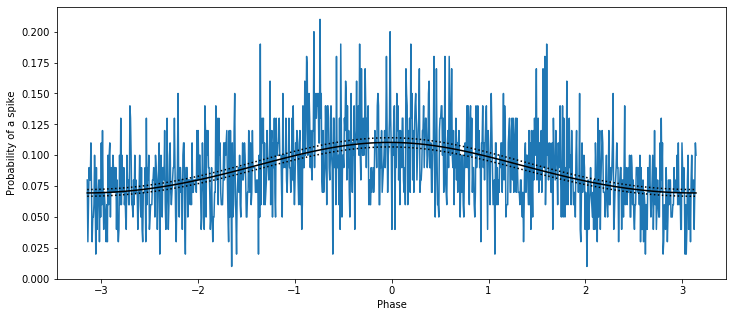

In [43]:
Wn = [44,46]                       
b = signal.firwin(ord, Wn, nyq=fNQ, pass_zero=False, window='hamming');

del phi
phi=np.zeros([K,N])                
for k in np.arange(K):             
    Vlo = signal.filtfilt(b, 1, y[k,:])       
    phi[k,:] = np.angle(signal.hilbert(Vlo))  

n_reshaped   = np.copy(n)
n_reshaped   = np.reshape(n_reshaped,-1)   
phi_reshaped = np.reshape(phi, -1)         
                                           
X            = np.transpose([np.ones(np.shape(phi_reshaped)), np.cos(phi_reshaped), np.sin(phi_reshaped)])
Y            = np.transpose([n_reshaped])  

model = sm.GLM(Y,X,family=sm.families.Poisson())    
res   = model.fit()                                 

phi_predict = np.linspace(-np.pi, np.pi, 100)      
X_predict   = np.transpose([np.ones(np.shape(phi_predict)), np.cos(phi_predict), np.sin(phi_predict)])
Y_predict   = res.get_prediction(X_predict, linear='False')

FTA, phi_axis = FTA_function(y,n,t,Wn)       

plot(phi_axis, FTA)                          
plot(phi_predict, Y_predict.predicted_mean, 'k')
plot(phi_predict, Y_predict.conf_int(), 'k:')
xlabel('Phase')
ylabel('Probability of a spike');
                        

pval1=res.pvalues[1];       
pval2=res.pvalues[2];       
print(pval1, pval2)
pval1=res.pvalues[1];       
pval2=res.pvalues[2];       
print(pval1, pval2)



In [44]:
#Remover spikes e GLM

(np.mean(np.sum(n_thinned_reshaped))/N) / (np.mean(np.sum(n_reshaped))/N)

NameError: name 'n_thinned_reshaped' is not defined